In [1]:
import numpy as np
import random as rm
import pandas as pd
from random import seed
from random import random
import matplotlib.pyplot as plt
from pylab import *
from scipy.optimize import curve_fit
from scipy.stats import bernoulli, binom, norm
from scipy import integrate
import time

In [2]:
def f_pi(x, mu, sigma, alpha):
    val = 0
    for i in range(len(mu)):
        val += alpha[i]*norm.pdf(x, mu[i], sigma[i])
    return val
    
def f_eta_unnormalized(x, mu, sigma, alpha, p):
    return f_pi(x, mu, sigma, alpha)**p

def compute_c(mu, sigma, alpha, p):
    def f_eta_unnormalized_temp(x):
        return f_eta_unnormalized(x, mu, sigma, alpha, p)
    c = integrate.quad(f_eta_unnormalized_temp, -np.inf, np.inf)[0]
    return c

# c = compute_c(mu, sigma, alpha, p)
    
def f_eta(x, mu, sigma, alpha, p, c):
    return f_eta_unnormalized(x, mu, sigma, alpha, p)/c

def g(x, mu, sigma, alpha, p, c):
    return(f_pi(x, mu, sigma, alpha)/f_eta(x, mu, sigma, alpha, p, c))

In [3]:
def p_kernel(y0, prop_sig_y, n, mu, sigma, alpha, p):
        count = 0
        Yn = y0
        estimator = np.array([y0])
        while count < n:
            y = np.random.normal(Yn, prop_sig_y)
            u = np.random.uniform(0,1)
            a = min(f_eta_unnormalized(y, mu, sigma, alpha, p)/f_eta_unnormalized(Yn, mu, sigma, alpha, p), 1)
            if u <= a:
                estimator = np.append(estimator, y)
                Yn = y
                count += 1
        return estimator

In [4]:
def k_kernel_nsteps(z0, prop_sig_z, n, mu, sigma, alpha):
        count = 0
        Zn = z0
        estimator = np.array([z0])
        while count < n:
            z = np.random.normal(Zn, prop_sig_z)
            u = np.random.uniform(0,1)
            a = min(f_pi(z, mu, sigma, alpha)/f_pi(Zn, mu, sigma, alpha), 1)
            if u <= a:
                estimator = np.append(estimator, z)
                Zn = z
                count += 1
        return estimator

In [5]:
def k_kernel(Xn, prop_sig_x, mu, sigma, alpha):
    Xnew = k_kernel_nsteps(Xn, prop_sig_x, 1, mu, sigma, alpha)[-1]
    return(Xnew)

In [6]:
def sum_g(sum_old, yn, mu, sigma, alpha, p, c):
    return sum_old + g(yn, mu, sigma, alpha, p, c)

def prob_list(y, sum_old, prob_list_old, mu, sigma, alpha, p, c):
        a = sum_old/sum_g(sum_old, y, mu, sigma, alpha, p, c)
        prob_list = prob_list_old*a
        prob_list = np.append(prob_list, g(y, mu, sigma, alpha, p, c)/sum_g(sum_old, y, mu, sigma, alpha, p, c))
        return a

In [18]:
a = prob_list(np.array([[1,2],[2,3],[3,4]]), 0.75, 
              np.array([[0.1,0.1],[0.1,0.1],[0.1,0.5]]), mu, sigma, alpha, p, 1)
a

<>:6: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
<>:6: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
/var/folders/b9/hjwyjp4x1k56ymrfvjwxfkyc0000gn/T/ipykernel_65176/329229180.py:6: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  b= np.array([[2,3][1,4]])


TypeError: list indices must be integers or slices, not tuple

In [22]:
b = np.array([[1, 2], [3, 4]])
print(b)
c = np.append(b,[2,3])
print(c)

[[1 2]
 [3 4]]
[1 2 3 4 2 3]


In [14]:
print(sum(3))

3


In [8]:
def simulate(mu, sigma, alpha, p, n, y0_list, prop_sig_x, prop_sig_y, x0_list, eps, N):
    
    c = compute_c(mu, sigma, alpha, p)
    
    X_matrix = np.empty(shape=(N,0),dtype='float')
    Y_matrix = np.empty(shape=(N,0),dtype='float')
    Y_matrix = np.insert(Y_matrix,0,y0_list,axis=1)
    X_matrix = np.insert(X_matrix,0,x0_list,axis=1)
    
    sum_Gs = 0
    Prob_matrix = np.empty(shape=(N,0),dtype='float')
    Prob_list = []
        
    for i in (y0_list):
        sum_Gs += g(i, mu, sigma, alpha, p, c)
            
    for i in y0_list:
        Prob_list.append(g(i, mu, sigma, alpha, p, c)/sum_Gs)
    Prob_matrix = np.insert(Prob_matrix, 0, Prob_list, axis=1)
        
    for i in range(n):
        sum_g = 0
        y_list = []
        x_list = []
        for j in range(N):
            y_list.append(p_kernel(Y_matrix[j][-1], prop_sig_y, n, mu, sigma, alpha, p)[-1])
            sum_g += g(y_list[j], mu, sigma, alpha, p, c)
            
        # Prob_matrix_old = np.insert(Prob_matrix, len(Prob_matrix[0]), np.zeros(N), axis=1)
        Prob_matrix = prob_list(Y_matrix[:,i], sum_Gs, Prob_matrix, mu, sigma, alpha, p, c)
        Y_matrix = np.insert(Y_matrix, len(Y_matrix[0]), y_list, axis=1)
        Y_matrix_flatten = Y_matrix.flatten()
        Prob_matrix_flatten = Prob_matrix.flatten()
        sum_Gs += sum_g
        '''    
        for j in range(N):
            b = bernoulli(epsilon).rvs(1)
            if b == 0:
                x_list.append(k_kernel(X_matrix[j][-1], prop_sig_x, mu, sigma, alpha))
            if b == 1:
                x_list.append(np.random.choice(Y_matrix_flatten, p = Prob_matrix_flatten))
            
        X_matrix = np.insert(X_matrix, len(X_matrix[0])-1, x_list, axis=1)
        
    X_list = X_matrix.flatten()
    '''
        
    return len(Y_matrix_flatten), len(Prob_matrix_flatten)

In [12]:
epsilon = 0.01
y0 = [1,2,3,4]
x0 = [6,7,8,8]
n = 3
prop_sig_x = 2
prop_sig_y = 2
mu = np.array([0, 3])
sigma = np.array([1, 4])
alpha = np.array([0.3, 0.7])
N = len(x0)
p = 0.4

x_out = simulate(mu, sigma, alpha, p, n, y0, prop_sig_x, prop_sig_y, x0, epsilon, N)

In [10]:
print(x_out[0], x_out[1])

16 4


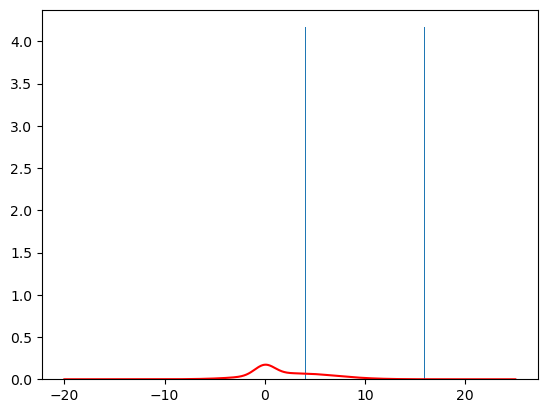

In [11]:
f_pi_plot = lambda z: f_pi(z, mu, sigma, alpha)

plt.hist(x_out, density = True, bins = 100)

t = np.linspace(-20,25,1000)
vals = f_pi_plot(t)

plt.plot(t,vals, 'r')
plt.show()

In [90]:
y0 = [1,2,3,4]
Y_matrix = np.empty(shape=(N,0),dtype='float')
Y_matrix = np.insert(Y_matrix,0,y0,axis=1)

In [91]:
Y_matrix

array([[1.],
       [2.],
       [3.],
       [4.]])

In [94]:
Prob_matrix = np.empty(shape=(N,0),dtype='float')
Prob_matrix_old = np.insert(Prob_matrix, len(Prob_matrix[0]), np.zeros(N), axis=1)
Prob_matrix_old

array([[0.],
       [0.],
       [0.],
       [0.]])

In [93]:
Prob_matrix_old = np.insert(Prob_matrix, len(Prob_matrix[0]), np.zeros(N), axis=1)
Prob_matrix_old

array([[1., 0.],
       [2., 0.],
       [3., 0.],
       [4., 0.]])